In [ ]:
# ========== import packages needed ============ #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = (8,6)
plt.rcParams['figure.edgecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.grid'] = True
%config InlineBackend.figure_formats = {'png', 'retina'}
%load_ext autoreload
%autoreload 2
%alias_magic t time

import sys
sys.path.append('/home/keisuke/script/script/')
sys.path.append('/home/keisuke/script/script/gbproc_cpp/build')
from rhea_comm.lib_read_rhea import *
import gbirdproc as gbp
import mkid_pylibs as klib
from analyzer_db.kidslist import KidsList
from gb_cal.misc.misc import *
from gb_cal.moon.moon_fit_new import get_destripe_sqdata

import glob
import datetime

Created `%t` as an alias for `%time`.
Created `%%t` as an alias for `%%time`.


In [2]:
# import
from gbpipe_package import gbpipe
from gb_cal.readdata.planet_center import calc_rmat_mc, calc_rmat_mcz
from gb_cal.misc.misc import get_moon_altaz_skm, _astro_pos, save_pkl, read_pkl
import healpy as hp

In [ ]:
def calc_mc_data_inv(theta, phi, utime, azoff, eloff):
      mctheta = theta + 90
      phi[phi < 0] += 360
      mcphi = phi
      obs_tmp = hp.ang2vec(theta = np.deg2rad(mctheta), phi = np.deg2rad(mcphi))
      rmat = calc_rmat_mc(utime)
      raw_vec = np.einsum('kij,kj->ki',rmat, obs_tmp)
      rawtheta, rawphi = np.rad2deg(hp.vec2ang(np.array(raw_vec)))

      elraw = 90 - rawtheta - eloff
      azraw = (360 + rawphi + azoff)%360

      return elraw, azraw, rmat

In [ ]:
def calc_mc_map(mc_thetas, mc_phis, phases, nside = 1024):
      hitmaps = []
      hpxmaps = []
      maxpixs = []
      npix = hp.nside2npix(nside)
      sum_hpxmap = np.zeros(npix)
      for i, (itheta, iphi, iphase) in enumerate(zip(mc_thetas, mc_phis, phases)):
          ipix = hp.ang2pix(nside, theta=np.deg2rad(itheta), phi=np.deg2rad(iphi))
          imaxind = np.argmax(iphase)
          maxpix =  hp.ang2pix(nside, theta=np.deg2rad(itheta[imaxind]), phi=np.deg2rad(iphi[imaxind]))
          hitmap = np.full(npix,hp.UNSEEN)
          ind,n = np.unique(ipix, return_counts=True)
          hitmap[ind] = n
          hpxmap = np.zeros(npix)
          np.add.at(hpxmap, ipix, iphase/np.max(iphase))
          hpxmap[hitmap==hp.UNSEEN] = hp.UNSEEN
          hpxmap[hitmap!=hp.UNSEEN] /= hitmap[hitmap!=hp.UNSEEN]
          hitmaps.append(hitmap)
          hpxmaps.append(hpxmap)
          maxpixs.append(maxpix)
      for i, iphase in enumerate(phases):
          sum_hpxmap[hitmaps[i]!=hp.UNSEEN] += hpxmaps[i][hitmaps[i]!=hp.UNSEEN]

      return hitmaps, hpxmaps, maxpixs, sum_hpxmap

In [ ]:
def calc_mc_data2(maz, mel, azoff, eloff, rmat_inv):
      obs_tmp = hp.ang2vec(theta = np.deg2rad(90 - mel), phi = np.deg2rad(360 - maz))
      mc_obs_vec = np.einsum('kij,ki->kj',rmat_inv, obs_tmp)
      mc_obs_theta, mc_obs_phi = np.rad2deg(hp.vec2ang(np.array(mc_obs_vec)))
      return mc_obs_theta, mc_obs_phi

In [ ]:
# ============= define rotation matrix to transform the coordinates =============== #
# azoffcen : azimuth offset of central kid ( kid17 of GB07 )
# eloffcen : elevation offset of central kid ( kid17 of GB07 )
# ============= using this rotation matrix, beam centered coordinates could be given with 70deg elevation ============== #
def rerot_mc70(mcdata, azoff, eloff, azoffcen, eloffcen):
    elraw, azraw, rmat = calc_mc_data_inv(mcdata['theta'], mcdata['phi'], mcdata['utime'], azoff, eloff)
    rmat_raw = gbpipe.gbdir.euler_ZYZ((360 - (360 - azraw + azoffcen), - elraw - eloffcen + 70, 0), deg=True)
    malt, maz = get_moon_altaz_skm(mcdata['utime'])
    theta, phi = calc_mc_data2(maz, malt, azoffcen, eloffcen, rmat_raw)
    return theta, phi

In [ ]:
# ============= define rotation matrix to transform the coordinates =============== #
# azoffcen : azimuth offset of central kid ( kid17 of GB07 )
# eloffcen : elevation offset of central kid ( kid17 of GB07 )
# ============= using this rotation matrix, beam centered coordinates could be given with 0deg elevation ( almost the same as projection of plane ) ============== #
def rerot_mc0(mcdata, azoff, eloff, azoffcen, eloffcen):
    elraw, azraw, rmat = calc_mc_data_inv(mcdata['theta'], mcdata['phi'], mcdata['utime'], azoff, eloff)
    rmat_raw = gbpipe.gbdir.euler_ZYZ((360 - (360 - azraw + azoffcen), - elraw - eloffcen , 0), deg=True)
    malt, maz = get_moon_altaz_skm(mcdata['utime'])
    theta, phi = calc_mc_data2(maz, malt, azoffcen, eloffcen, rmat_raw)
    return theta, phi

In [ ]:
mcdir = '/data/keisuke/gb/save/mcdata/'
mcpaths = sorted(glob.glob(mcdir + '*'))

mc_measid = [int(ip.split('_')[1]) for ip in mcpaths]
mc_kidid = [int(ip.split('_')[-1][3:5]) for ip in mcpaths]

fitdir = '/data/keisuke/gb/save/moonfit/desfit/'
fitpaths = sorted(glob.glob(fitdir + '*'))

fit_measid = [int(ip.split('_')[2]) for ip in fitpaths]
fit_kidid = [int(ip.split('_')[-1][3:5]) for ip in fitpaths]

fitdf = pd.DataFrame()
fitdf['meas_id'] = fit_measid
fitdf['kidid'] = fit_kidid
fitdf['fitpath'] = fitpaths

mcdf = pd.DataFrame()
mcdf['meas_id'] = mc_measid
mcdf['kidid'] = mc_kidid
mcdf['mcpath'] = mcpaths

df = pd.merge(fitdf, mcdf, on=['meas_id', 'kidid'])

df['daq'] = [i.split('_')[2] for i in df['mcpath'].values]
df['chip'] = [i.split('_')[3] for i in df['mcpath'].values]

azoffs = []
eloffs = []

# ================= sort the azimuth and elevation offsets ===================== #
for imeas_id, idaq, ichip, ikidid in zip(df['meas_id'], df['daq'], df['chip'], df['kidid']):
    offsets = read_pkl(f'/data/keisuke/gb/save/offset_tmp/offset_{imeas_id}_' + idaq + '_' + ichip + '_noazoff.pkl')
    azoff = offsets['azoff'][np.where(np.array(offsets['kidid']) == ikidid)[0][0]]
    eloff = offsets['eloff'][np.where(np.array(offsets['kidid']) == ikidid)[0][0]]
    azoffs.append(azoff)
    eloffs.append(eloff)
df['azoff'] = azoffs
df['eloff'] = eloffs

# After Boresight Rotation

In [ ]:
# ===================== choose the measurement id of GB07 ( center array ) ================ #

imeas_id = 10960

In [ ]:
# ===================== get the azimuth and elevation offsets of GB07 array ==================== #
idaq = 'GB07'
ichip = '220'
ikidid = 17
offsets = read_pkl(f'/data/keisuke/gb/save/offset_tmp/offset_{imeas_id}_' + idaq + '_' + ichip + '_noazoff.pkl')
azoffcen = offsets['azoff'][np.where(np.array(offsets['kidid']) == ikidid)[0][0]]
eloffcen = offsets['eloff'][np.where(np.array(offsets['kidid']) == ikidid)[0][0]]

In [ ]:
# ===================== bad kids for each array ================ #

bad_GB01 = np.array([7,8,9,10,13,14])
bad_GB02 = np.array([0, 5, 14, 19])
bad_GB03 = np.array([0,1])
bad_GB04 = np.array([0,2, 3,4, 5, 6,7, 10, 13, 15])
bad_GB05 = np.array([])
bad_GB06 = np.array([2, 3, 4, 9, 18])
bad_GB07 = np.array([14])

In [ ]:
# ================== all measurement ids using ====================== #

#meas_ids = [4918, 4917, 4931, 4928, 4927, 4929, 4861]
#meas_ids = [7985, 7983, 7993, 7990, 7986, 7991, 7989]
meas_ids = [10960, 10954,10957,10958,10961,10962]
#chips = ['3A', '2A', '3B', '1A', '2B', '1B', '220']
chips = ['220', '3B','1B','1A','2B','2A']
#bads = [bad_GB01, bad_GB02, bad_GB03, bad_GB04, bad_GB05, bad_GB06, bad_GB07]
bads = [bad_GB07, bad_GB03,bad_GB06,bad_GB04,bad_GB05,bad_GB02]

In [ ]:
# ==================== masking kids ( there are bad kids for each meas_id ) ================== #
exclude_indices_10962 = [5,19]
mask10962 = np.ones(20, dtype=bool)
mask10962[exclude_indices_10962] = False
print(mask10962)

[ True  True  True  True  True False  True  True  True  True  True  True
  True  True  True  True  True  True  True False]


10960


        Use get_body("moon") instead. [gb_cal.misc.misc]


10954


        Use get_body("moon") instead. [gb_cal.misc.misc]


10957


        Use get_body("moon") instead. [gb_cal.misc.misc]


10958


        Use get_body("moon") instead. [gb_cal.misc.misc]


10961


        Use get_body("moon") instead. [gb_cal.misc.misc]


10962


        Use get_body("moon") instead. [gb_cal.misc.misc]


                       kid0      kid1      kid2      kid3      kid4  \
dAz(10960, '220') -1.799540  1.666336 -1.344566  0.865107 -0.421370   
dEl(10960, '220') -1.438973 -1.536638 -0.692290 -0.026085  0.780751   
dAz(10954, '3B')  -1.910007 -1.029870 -0.606359 -0.162365 -1.021605   
dEl(10954, '3B')  -8.258081 -8.301583 -7.581083 -8.319080 -6.793496   
dAz(10962, '2A')   1.919239  2.021870  1.219815 -0.036897 -0.650336   
dEl(10962, '2A')   5.062448  5.291127  6.846314  7.651580  5.394829   
dAz(10957, '1B')  -4.262944 -7.599163 -4.712876 -6.813040 -6.813040   
dEl(10957, '1B')  -1.768226 -1.585891 -2.473251 -3.129488 -3.129488   
dAz(10958, '1A')   7.750206  4.180362  7.265068  5.027763  6.855316   
dEl(10958, '1A')  -2.222133 -2.092540 -2.959723 -3.645083 -2.180599   
dAz(10961, '2B')   4.755728  5.792852  6.284785  5.195192  5.309548   
dEl(10961, '2B')   2.655571  3.986617  4.752178  1.790328  3.296207   

                        kid5      kid6      kid7      kid8      kid9  ...  \

/home/keisuke/analysis/moon/gb_cal/readdata/myenv/lib/python3.10/site-packages/pandas/core/indexes/base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


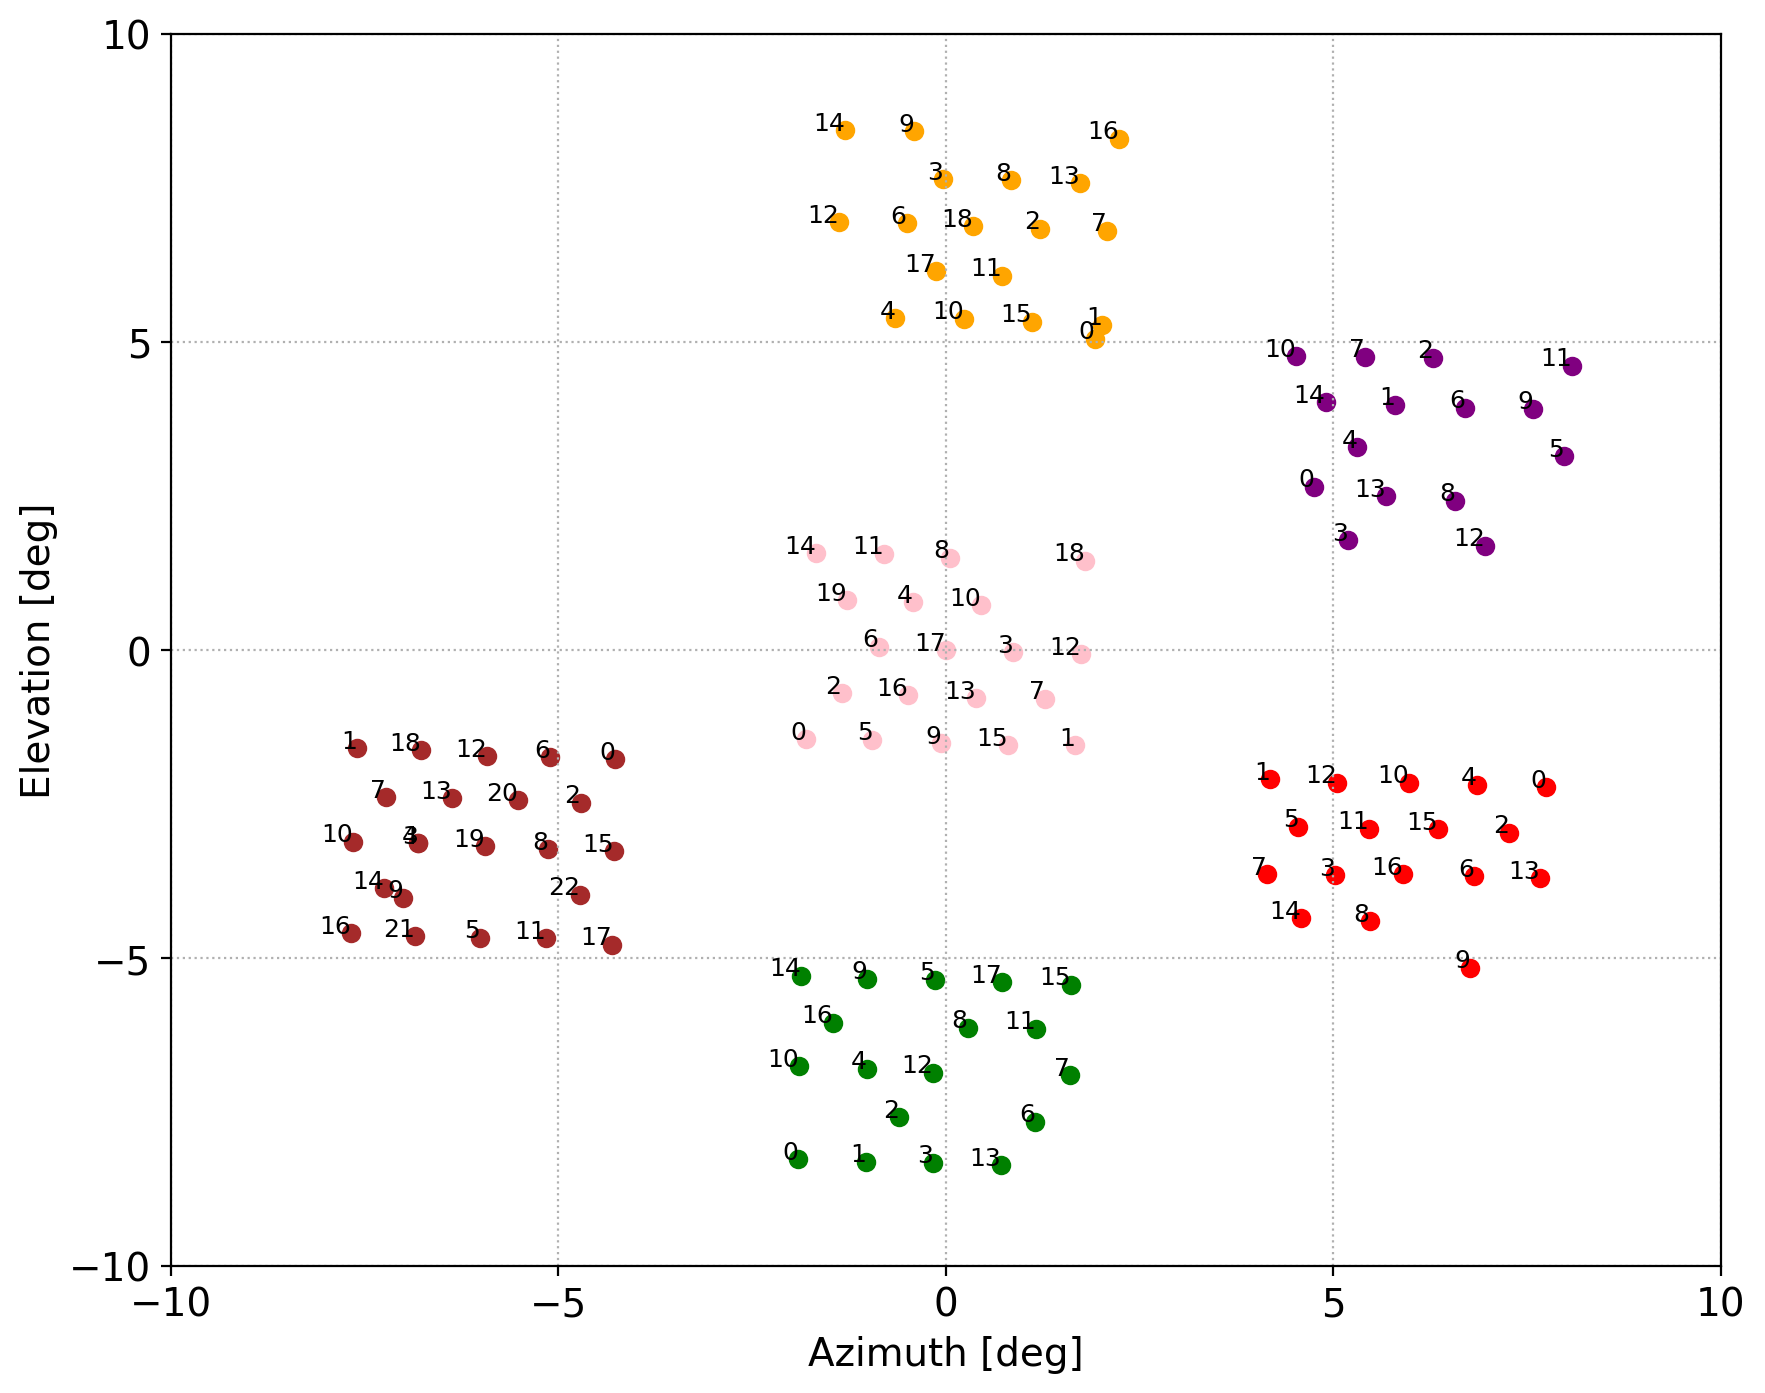

-6.1804600483707085e-06
-6.127005082134929e-05
-1.6141082272525813
-2.6412515358397752


In [ ]:
# =================== calculate detectors position with full array ==================== #

sum_hpxmaps = []
maxpixs = []
nside = 1024
npix = hp.nside2npix(nside)
comb_sum_hpxmap = np.zeros(npix)

dAz = []
dEl = []

plt.figure(figsize=(10, 8))
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
#plt.title('Moon Azimuth and Elevation All Wafer')
plt.grid(True)

for h, (imeas_id, ichip, ibad) in enumerate(zip(meas_ids, chips, bads)):
    chip = ichip
    meas_id = imeas_id
    print(meas_id)

    dftmp = df[df['chip'] == chip][df[df['chip'] == chip]['meas_id'] == meas_id].reset_index()

    mc_thetas = []
    mc_phis = []
    mc_phases = []
    desdatas = []
    for i in range(len(dftmp.index)):
        mcdata = read_pkl(dftmp['mcpath'][i])
        desdata = get_destripe_sqdata(mcdata, r = 1.5, maskr = 1)
        desdatas.append(desdata)
        azoff = dftmp['azoff'][i]
        eloff = dftmp['eloff'][i]
        # ================ apply rotation matrix =================== #
        mc_theta, mc_phi = rerot_mc0(desdata, azoff, eloff, azoffcen, eloffcen)
        mc_thetas.append(mc_theta)
        mc_phis.append(mc_phi)
        mc_phases.append(desdata['phase'])
        del mcdata, desdata, azoff, eloff

    hitmaps, hpxmaps, maxpix, sum_hpxmap = calc_mc_map(mc_thetas, mc_phis, mc_phases)
    max_thetas = []
    max_phis = []
    labels = []
    columns = []

    # ================= pick up the azimuth and elevation at which phase response become maximum . That point can regarded as pointing of detectors ==================== #
    for i, (theta_list, phi_list, phase_list) in enumerate(zip(mc_thetas, mc_phis, mc_phases)):
        max_phase_index = np.argmax(phase_list)
        max_theta = theta_list[max_phase_index]
        max_phi = phi_list[max_phase_index]
        max_thetas.append(max_theta)
        max_phis.append(max_phi)
        labels.append(i)
        columns.append(f'kid{i}')

    itheta_max_array = np.array(max_thetas)
    iphi_max_array = np.array(max_phis)

    # ================== correct the azimuth and elevation values ==================== #
    filtered_iphi_max_array = [-(az - 360) if az >= 345 else -az for az in iphi_max_array]
    filtered_itheta_max_array = [90 - el for el in itheta_max_array]

    # ================== for each array, calculate the pointing and make the (daz, del) list from center kid ==================== #
    if meas_id == 10960:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)
        center_phi = iphi_center_17[17]
        center_theta = itheta_center_17[17]

        rotation_angle_1_0 = np.rad2deg(np.arctan((itheta_center_17[1] - itheta_center_17[0]) / (iphi_center_17[1] - iphi_center_17[0])))
        rotation_angle_12_6 = np.rad2deg(np.arctan((itheta_center_17[12] - itheta_center_17[6]) / (iphi_center_17[12] - iphi_center_17[6])))

        d_az_list = []
        d_el_list = []

        # ============= relative position from center azimuth =================== #
        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        # ============= relative position from center elevarion =================== #
        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d1 = pd.DataFrame([d_az_list], columns=columns)
        df_d1.loc[1] = d_el_list
        df_d1.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]
        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='pink', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    # =================== just the same for other arrays ( very ugly codes ) ===================== #
    elif meas_id == 10954:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d2 = pd.DataFrame([d_az_list], columns=columns)
        df_d2.loc[1] = d_el_list
        df_d2.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='green', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 10962:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d3 = pd.DataFrame([d_az_list], columns=columns)
        df_d3.loc[1] = d_el_list
        df_d3.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17[mask10962], itheta_center_17[mask10962], marker='o',c='orange', label=f'{imeas_id}_chip={ichip}')
        for az, el, label,m in zip(iphi_center_17, itheta_center_17, labels, mask10962):
            if m:
                plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 10957:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d4 = pd.DataFrame([d_az_list], columns=columns)
        df_d4.loc[1] = d_el_list
        df_d4.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='brown',label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 10958:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d5 = pd.DataFrame([d_az_list], columns=columns)
        df_d5.loc[1] = d_el_list
        df_d5.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o', c='red', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 10961:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d6 = pd.DataFrame([d_az_list], columns=columns)
        df_d6.loc[1] = d_el_list
        df_d6.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o', c='purple',label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    for i in range(len(hitmaps)):
        if i in ibad:
            pass
        elif i in []:
            pass
        else:
            sum_hpxmap[hitmaps[i]!=hp.UNSEEN] += hpxmaps[i][hitmaps[i]!=hp.UNSEEN]
            comb_sum_hpxmap[hitmaps[i]!=hp.UNSEEN] += hpxmaps[i][hitmaps[i]!=hp.UNSEEN]

    sum_hpxmaps.append(sum_hpxmap)
    maxpixs.append(maxpix)

# ================= save the daz and del to csv files ===================== #
df_sum = pd.concat([df_d1, df_d2, df_d3, df_d4, df_d5, df_d6])
df_sum.to_csv("dAz_dEl_after_0.csv")
print(df_sum)

# ======= plot the positions ========= #
plt.xlim([-10,10])
plt.xticks([-10.0, -5.0, 0, 5.0, 10.0])
plt.ylim([-10,10])
plt.yticks([-10.0, -5.0, 0, 5.0, 10.0])
plt.show()

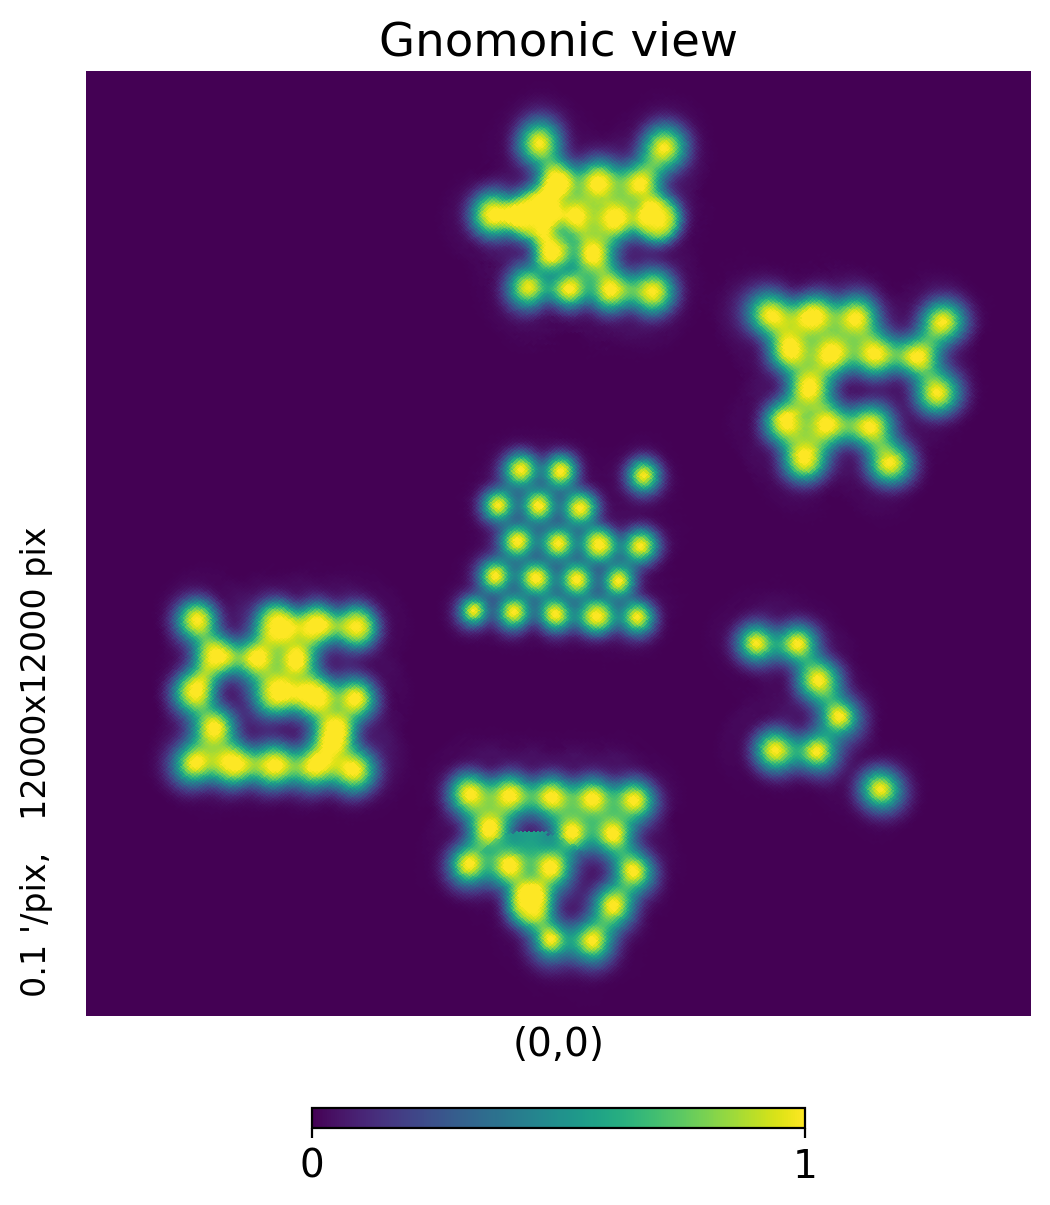

In [ ]:
psize = 12000
hp.gnomview(comb_sum_hpxmap, xsize=psize, ysize = psize, min = 0, max = 1, reso = 0.1)

10960


        Use get_body("moon") instead. [gb_cal.misc.misc]


10954


        Use get_body("moon") instead. [gb_cal.misc.misc]


10957


        Use get_body("moon") instead. [gb_cal.misc.misc]


10958


        Use get_body("moon") instead. [gb_cal.misc.misc]


10961


        Use get_body("moon") instead. [gb_cal.misc.misc]


10962


        Use get_body("moon") instead. [gb_cal.misc.misc]


                        kid0       kid1       kid2       kid3       kid4  \
dAz(10960, '220')  -4.911198   4.529284  -3.800000   2.524792  -1.279733   
dEl(10960, '220')  -1.511481  -1.598552  -0.734200  -0.043998   0.776329   
dAz(10954, '3B')   -3.986838  -2.148560  -1.297973  -0.338655  -2.249396   
dEl(10954, '3B')   -8.320545  -8.319731  -7.587538  -8.319531  -6.812342   
dAz(10962, '2A')    7.379616   7.883884   5.308223  -0.171005  -2.566119   
dEl(10962, '2A')    4.946176   5.160247   6.793185   7.651528   5.381142   
dAz(10957, '1B')  -11.357101 -19.914087 -12.155419 -16.878561 -16.878561   
dEl(10957, '1B')   -2.166229  -2.836308  -2.944354  -4.077600  -4.077600   
dAz(10958, '1A')   19.761704  10.987814  18.058300  12.341028  17.640549   
dEl(10958, '1A')   -3.487457  -2.470078  -4.042250  -4.155369  -3.178186   
dAz(10961, '2B')   15.584190  20.168923  22.688319  16.221098  17.903792   
dEl(10961, '2B')    2.044875   3.020677   3.570661   1.095685   2.511677   

           

/home/keisuke/analysis/moon/gb_cal/readdata/myenv/lib/python3.10/site-packages/pandas/core/indexes/base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


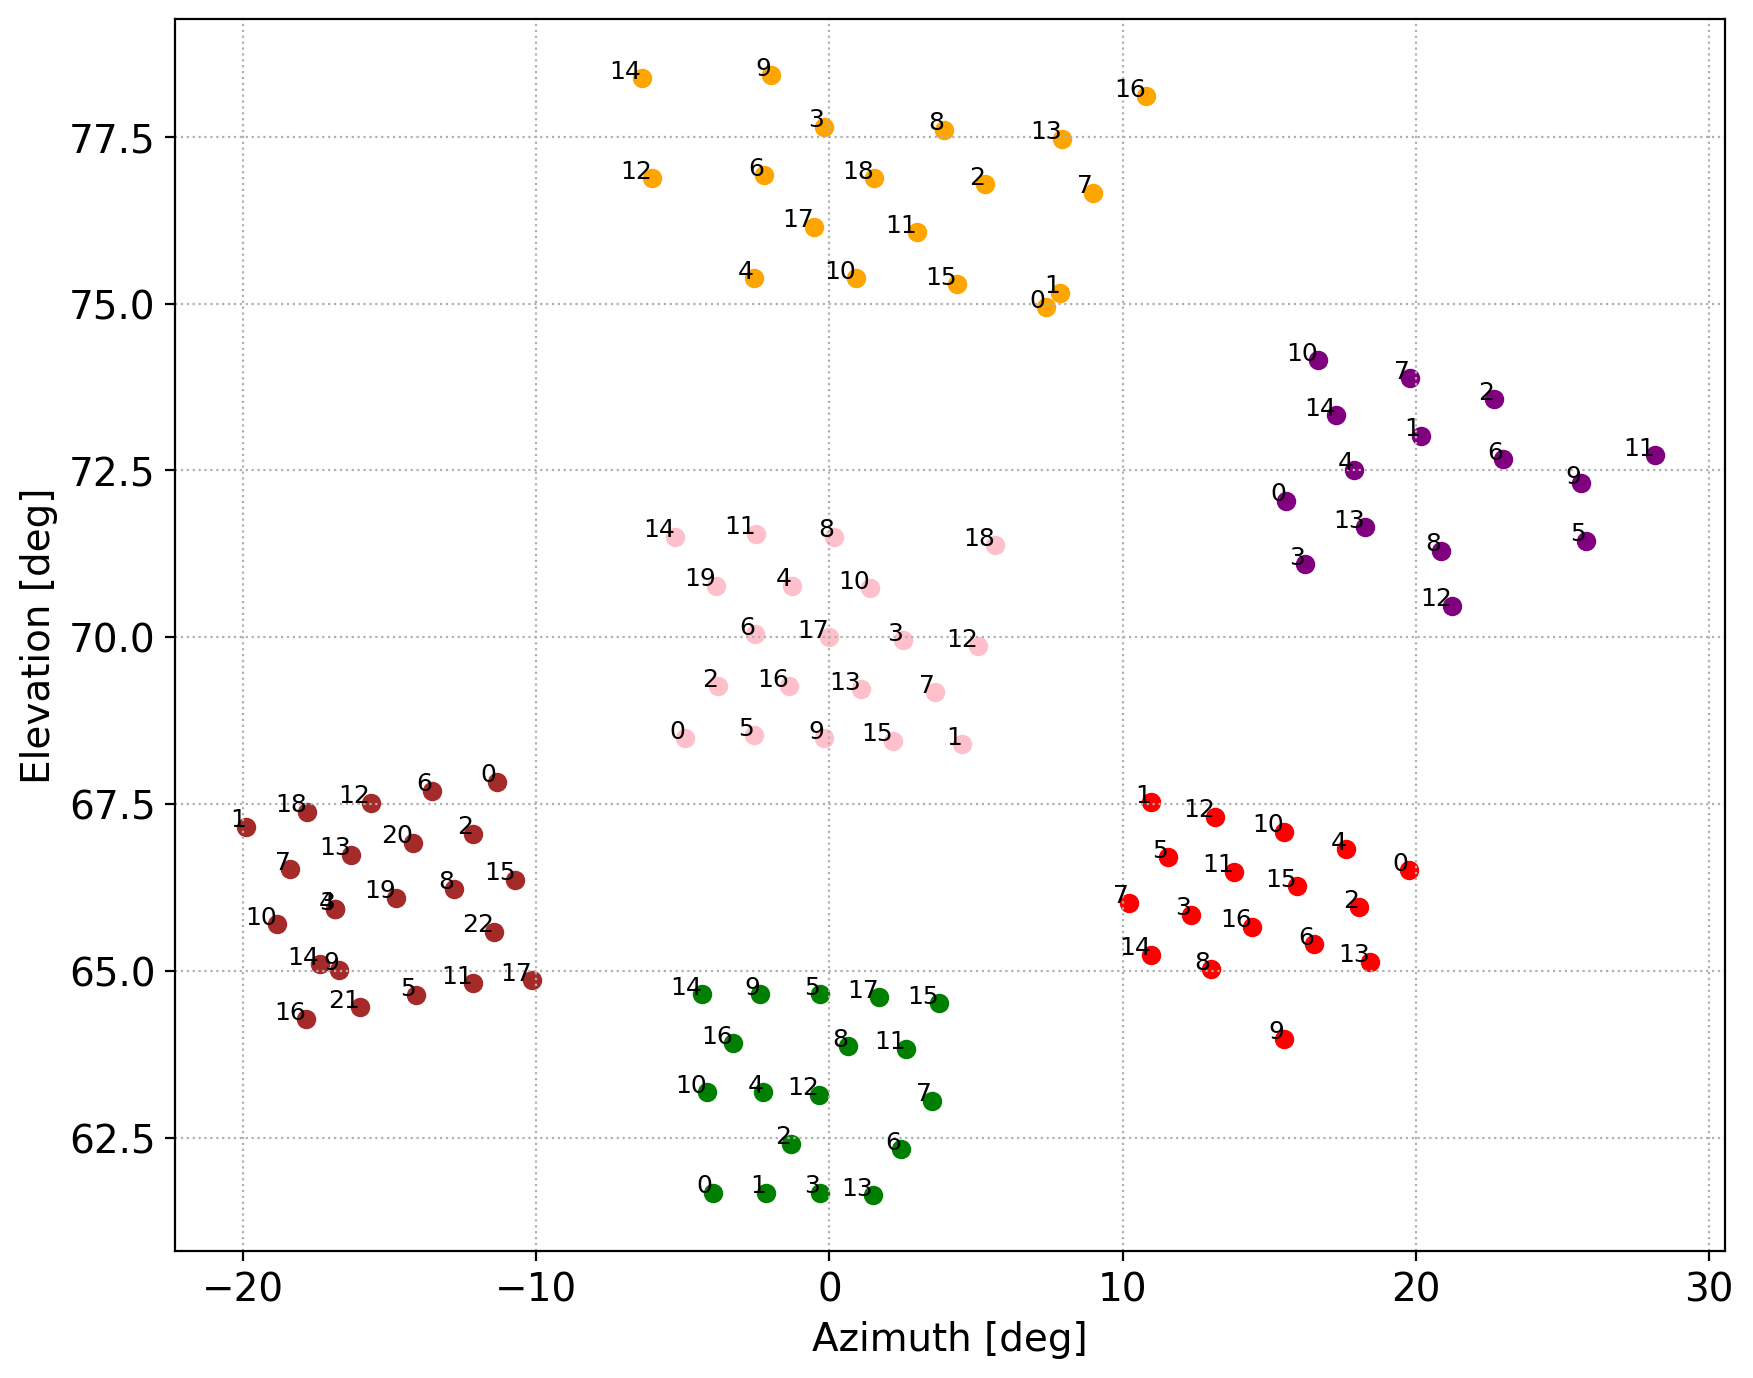

-1.807040319264166e-05
69.99993872994827
-0.5284345257976439
-1.3168056859059416


In [ ]:
# ================== check the pointing with elevation 70deg ===================== #
# ================== with 70deg, effect of distortion from spherical coordinate appears ================ #
sum_hpxmaps = []
maxpixs = []
nside = 1024
npix = hp.nside2npix(nside)
comb_sum_hpxmap = np.zeros(npix)

dAz = []
dEl = []

plt.figure(figsize=(10, 8))
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
#plt.title('Moon Azimuth and Elevation All Wafer')
plt.grid(True)

for h, (imeas_id, ichip, ibad) in enumerate(zip(meas_ids, chips, bads)):
    chip = ichip
    meas_id = imeas_id
    print(meas_id)

    dftmp = df[df['chip'] == chip][df[df['chip'] == chip]['meas_id'] == meas_id].reset_index()

    mc_thetas = []
    mc_phis = []
    mc_phases = []
    desdatas = []
    for i in range(len(dftmp.index)):
        mcdata = read_pkl(dftmp['mcpath'][i])
        desdata = get_destripe_sqdata(mcdata, r = 1.5, maskr = 1)
        desdatas.append(desdata)
        azoff = dftmp['azoff'][i]
        eloff = dftmp['eloff'][i]
        mc_theta, mc_phi = rerot_mc70(desdata, azoff, eloff, azoffcen, eloffcen)
        mc_thetas.append(mc_theta)
        mc_phis.append(mc_phi)
        mc_phases.append(desdata['phase'])
        del mcdata, desdata, azoff, eloff

    hitmaps, hpxmaps, maxpix, sum_hpxmap = calc_mc_map(mc_thetas, mc_phis, mc_phases)
    max_thetas = []
    max_phis = []
    labels = []
    columns = []

    for i, (theta_list, phi_list, phase_list) in enumerate(zip(mc_thetas, mc_phis, mc_phases)):
        max_phase_index = np.argmax(phase_list)
        max_theta = theta_list[max_phase_index]
        max_phi = phi_list[max_phase_index]
        max_thetas.append(max_theta)
        max_phis.append(max_phi)
        labels.append(i)
        columns.append(f'kid{i}')

    itheta_max_array = np.array(max_thetas)
    iphi_max_array = np.array(max_phis)

    filtered_iphi_max_array = [-(az - 360) if az >= 300 else -az for az in iphi_max_array]
    filtered_itheta_max_array = [90 - el for el in itheta_max_array]

    if meas_id == 10960:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)
        center_phi = iphi_center_17[17]
        center_theta = itheta_center_17[17]

        rotation_angle_1_0 = np.rad2deg(np.arctan((itheta_center_17[1] - itheta_center_17[0]) / (iphi_center_17[1] - iphi_center_17[0])))
        rotation_angle_12_6 = np.rad2deg(np.arctan((itheta_center_17[12] - itheta_center_17[6]) / (iphi_center_17[12] - iphi_center_17[6])))

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d1 = pd.DataFrame([d_az_list], columns=columns)
        df_d1.loc[1] = d_el_list
        df_d1.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='pink', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 10954:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d2 = pd.DataFrame([d_az_list], columns=columns)
        df_d2.loc[1] = d_el_list
        df_d2.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='green', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 10962:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d3 = pd.DataFrame([d_az_list], columns=columns)
        df_d3.loc[1] = d_el_list
        df_d3.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17[mask10962], itheta_center_17[mask10962], marker='o',c='orange', label=f'{imeas_id}_chip={ichip}')
        for az, el, label,m in zip(iphi_center_17, itheta_center_17, labels, mask10962):
            if m:
                plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 10957:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d4 = pd.DataFrame([d_az_list], columns=columns)
        df_d4.loc[1] = d_el_list
        df_d4.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='brown',label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 10958:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d5 = pd.DataFrame([d_az_list], columns=columns)
        df_d5.loc[1] = d_el_list
        df_d5.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o', c='red', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 10961:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d6 = pd.DataFrame([d_az_list], columns=columns)
        df_d6.loc[1] = d_el_list
        df_d6.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o', c='purple',label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    for i in range(len(hitmaps)):
        if i in ibad:
            pass
        elif i in []:
            pass
        else:
            sum_hpxmap[hitmaps[i]!=hp.UNSEEN] += hpxmaps[i][hitmaps[i]!=hp.UNSEEN]
            comb_sum_hpxmap[hitmaps[i]!=hp.UNSEEN] += hpxmaps[i][hitmaps[i]!=hp.UNSEEN]

    sum_hpxmaps.append(sum_hpxmap)
    maxpixs.append(maxpix)

df_sum = pd.concat([df_d1, df_d2, df_d3, df_d4, df_d5, df_d6])
df_sum.to_csv("dAz_dEl_after_70.csv")
print(df_sum)

plt.show()

# Before Boresight Rotation ( basically same as after)

In [ ]:
# ===================== choose the measurement id of GB07 ( center array ) ================ #

imeas_id = 7989

In [ ]:
idaq = 'GB07'
ichip = '220'
ikidid = 17
offsets = read_pkl(f'/data/keisuke/gb/save/offset_tmp/offset_{imeas_id}_' + idaq + '_' + ichip + '_noazoff.pkl')
azoffcen = offsets['azoff'][np.where(np.array(offsets['kidid']) == ikidid)[0][0]]
eloffcen = offsets['eloff'][np.where(np.array(offsets['kidid']) == ikidid)[0][0]]

In [ ]:

#meas_ids = [4918, 4917, 4931, 4928, 4927, 4929, 4861]
#meas_ids = [7985, 7983, 7993, 7990, 7986, 7991, 7989]
meas_ids = [7989, 7985, 7983, 7993, 7990, 7986, 7991]
#chips = ['3A', '2A', '3B', '1A', '2B', '1B', '220']
chips = ['220', '3A', '2A', '3B', '1A', '2B', '1B']
#chips = ['3B','1B','1A','220','2B','2A']
bads = [bad_GB07, bad_GB01, bad_GB02, bad_GB03, bad_GB04, bad_GB05, bad_GB06]
#bads = [bad_GB03,bad_GB06,bad_GB04,bad_GB07,bad_GB05,bad_GB02]

In [ ]:

exclude_indices_7990 = [10,13]
mask7990 = np.ones(17, dtype=bool)
mask7990[exclude_indices_7990] = False
print(mask7990)

[ True  True  True  True  True  True  True  True  True  True False  True
  True False  True  True  True]


7989


        Use get_body("moon") instead. [gb_cal.misc.misc]


7985


        Use get_body("moon") instead. [gb_cal.misc.misc]


7983


        Use get_body("moon") instead. [gb_cal.misc.misc]


7993


        Use get_body("moon") instead. [gb_cal.misc.misc]


7990


        Use get_body("moon") instead. [gb_cal.misc.misc]


7986


        Use get_body("moon") instead. [gb_cal.misc.misc]


7991


        Use get_body("moon") instead. [gb_cal.misc.misc]


                      kid0      kid1      kid2      kid3      kid4      kid5  \
dAz(7989, '220') -1.566215  1.893709 -1.229329  0.864628 -0.532666 -0.721943   
dEl(7989, '220') -1.648408 -1.309622 -0.876307  0.114212  0.723448 -1.569598   
dAz(7985, '3A')  -7.730683 -7.595082 -6.936271 -7.418753 -4.402997 -5.404560   
dEl(7985, '3A')   1.162255  3.444015  1.235820  1.939923  1.499830  2.881038   
dAz(7983, '2A')   1.216074  1.230034  0.198954 -1.453271 -1.439820  0.115501   
dEl(7983, '2A')   5.523102  5.524161  6.921754  7.619587  5.257362  6.572872   
dAz(7991, '1B')  -3.972645 -7.330282 -4.313041 -6.322721 -6.304885 -5.291527   
dEl(7991, '1B')  -2.335283 -2.665853 -3.130784 -4.011464 -4.040617 -5.447343   
dAz(7993, '3B')  -0.681020  0.214725  0.170115  1.061269 -0.032495  0.639175   
dEl(7993, '3B')  -8.457187 -8.367470 -6.294089 -8.252884 -6.873114 -5.323303   
dAz(7986, '2B')   4.412790  5.184853  5.564094  4.943960  4.794474  7.485616   
dEl(7986, '2B')   3.212431  4.771177  5.

/home/keisuke/analysis/moon/gb_cal/readdata/myenv/lib/python3.10/site-packages/pandas/core/indexes/base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


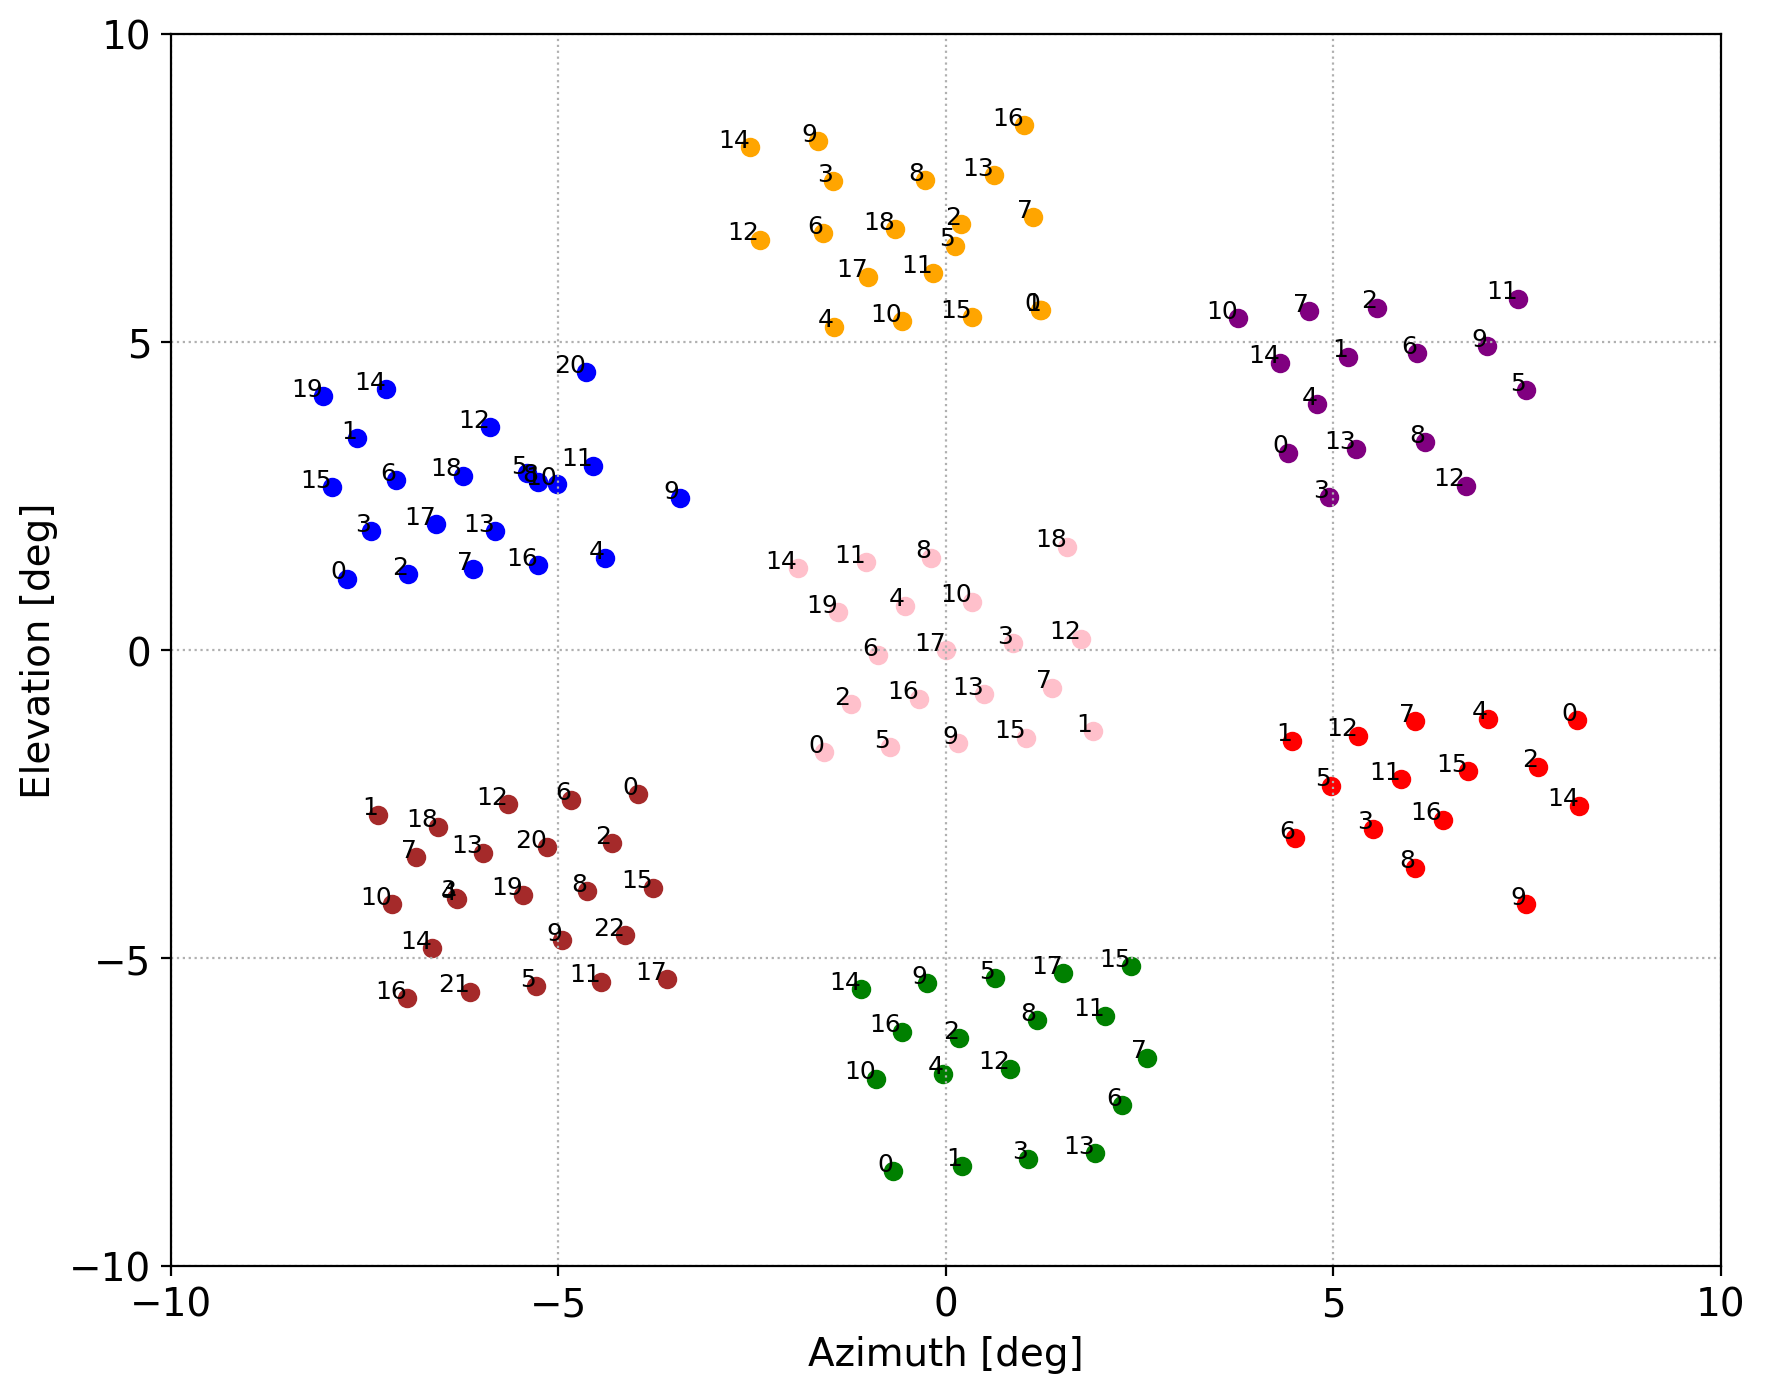

4.102237608094583e-05
-6.902986045531634e-05
5.5924276552081675
5.865027982864735


In [ ]:

sum_hpxmaps = []
maxpixs = []
nside = 1024
npix = hp.nside2npix(nside)
comb_sum_hpxmap = np.zeros(npix)

dAz = []
dEl = []

plt.figure(figsize=(10, 8))
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
#plt.title('Moon Azimuth and Elevation All Wafer')
plt.grid(True)

for h, (imeas_id, ichip, ibad) in enumerate(zip(meas_ids, chips, bads)):
    chip = ichip
    meas_id = imeas_id
    print(meas_id)

    dftmp = df[df['chip'] == chip][df[df['chip'] == chip]['meas_id'] == meas_id].reset_index()

    mc_thetas = []
    mc_phis = []
    mc_phases = []
    desdatas = []
    for i in range(len(dftmp.index)):
        mcdata = read_pkl(dftmp['mcpath'][i])
        desdata = get_destripe_sqdata(mcdata, r = 1.5, maskr = 1)
        desdatas.append(desdata)
        azoff = dftmp['azoff'][i]
        eloff = dftmp['eloff'][i]
        mc_theta, mc_phi = rerot_mc0(desdata, azoff, eloff, azoffcen, eloffcen)
        mc_thetas.append(mc_theta)
        mc_phis.append(mc_phi)
        mc_phases.append(desdata['phase'])
        del mcdata, desdata, azoff, eloff

    hitmaps, hpxmaps, maxpix, sum_hpxmap = calc_mc_map(mc_thetas, mc_phis, mc_phases)
    max_thetas = []
    max_phis = []
    labels = []
    columns = []

    for i, (theta_list, phi_list, phase_list) in enumerate(zip(mc_thetas, mc_phis, mc_phases)):
        max_phase_index = np.argmax(phase_list)
        max_theta = theta_list[max_phase_index]
        max_phi = phi_list[max_phase_index]
        max_thetas.append(max_theta)
        max_phis.append(max_phi)
        labels.append(i)
        columns.append(f'kid{i}')

    itheta_max_array = np.array(max_thetas)
    iphi_max_array = np.array(max_phis)

    filtered_iphi_max_array = [-(az - 360) if az >= 345 else -az for az in iphi_max_array]
    filtered_itheta_max_array = [90 - el for el in itheta_max_array]

    if meas_id == 7989:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)
        center_phi = iphi_center_17[17]
        center_theta = itheta_center_17[17]

        rotation_angle_1_0 = np.rad2deg(np.arctan((itheta_center_17[1] - itheta_center_17[0]) / (iphi_center_17[1] - iphi_center_17[0])))
        rotation_angle_12_6 = np.rad2deg(np.arctan((itheta_center_17[12] - itheta_center_17[6]) / (iphi_center_17[12] - iphi_center_17[6])))

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d1 = pd.DataFrame([d_az_list], columns=columns)
        df_d1.loc[1] = d_el_list
        df_d1.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='pink', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 7985:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d2 = pd.DataFrame([d_az_list], columns=columns)
        df_d2.loc[1] = d_el_list
        df_d2.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='blue', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 7983:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d3 = pd.DataFrame([d_az_list], columns=columns)
        df_d3.loc[1] = d_el_list
        df_d3.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='orange', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 7991:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d4 = pd.DataFrame([d_az_list], columns=columns)
        df_d4.loc[1] = d_el_list
        df_d4.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='brown',label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 7993:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d5 = pd.DataFrame([d_az_list], columns=columns)
        df_d5.loc[1] = d_el_list
        df_d5.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o', c='green', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 7986:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d6 = pd.DataFrame([d_az_list], columns=columns)
        df_d6.loc[1] = d_el_list
        df_d6.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o', c='purple',label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 7990:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d7 = pd.DataFrame([d_az_list], columns=columns)
        df_d7.loc[1] = d_el_list
        df_d7.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17[mask7990], itheta_center_17[mask7990], marker='o', c='red',label=f'{imeas_id}_chip={ichip}')
        for az, el, label, m  in zip(iphi_center_17, itheta_center_17, labels, mask7990):
          if m:
            plt.text(az, el, str(label), fontsize=9, ha='right')

    for i in range(len(hitmaps)):
        if i in ibad:
            pass
        elif i in []:
            pass
        else:
            sum_hpxmap[hitmaps[i]!=hp.UNSEEN] += hpxmaps[i][hitmaps[i]!=hp.UNSEEN]
            comb_sum_hpxmap[hitmaps[i]!=hp.UNSEEN] += hpxmaps[i][hitmaps[i]!=hp.UNSEEN]

    sum_hpxmaps.append(sum_hpxmap)
    maxpixs.append(maxpix)

df_sum = pd.concat([df_d1, df_d2, df_d3, df_d4, df_d5, df_d6, df_d7])
df_sum.to_csv("dAz_dEl_before_0.csv")
print(df_sum)

plt.xlim([-10,10])
plt.xticks([-10.0, -5.0, 0, 5.0, 10.0])
plt.ylim([-10,10])
plt.yticks([-10.0, -5.0, 0, 5.0, 10.0])
plt.show()

7989


        Use get_body("moon") instead. [gb_cal.misc.misc]


7985


        Use get_body("moon") instead. [gb_cal.misc.misc]


7983


        Use get_body("moon") instead. [gb_cal.misc.misc]


7993


        Use get_body("moon") instead. [gb_cal.misc.misc]


7990


        Use get_body("moon") instead. [gb_cal.misc.misc]


7986


        Use get_body("moon") instead. [gb_cal.misc.misc]


7991


        Use get_body("moon") instead. [gb_cal.misc.misc]


                       kid0       kid1       kid2       kid3       kid4  \
dAz(7989, '220')  -4.236960   5.197020  -3.445692   2.540445  -1.612999   
dEl(7989, '220')  -1.702842  -1.390372  -0.911049   0.096195   0.716403   
dAz(7985, '3A')  -22.809904 -25.075631 -20.720743 -22.789004 -13.638316   
dEl(7985, '3A')   -0.298495   1.862601   0.047312   0.539327   1.005609   
dAz(7983, '2A')    4.831571   4.887133   0.872817  -6.690438  -5.617792   
dEl(7983, '2A')    5.474894   5.474839   6.920330   7.539784   5.190993   
dAz(7991, '1B')  -10.345245 -18.425410 -10.848140 -15.182183 -15.123989   
dEl(7991, '1B')   -2.672984  -3.780584  -3.515319  -4.802068  -4.825943   
dAz(7993, '3B')   -1.413449   0.447079   0.381677   2.217752  -0.071402   
dEl(7993, '3B')   -8.465080  -8.368257  -6.294622  -8.272188  -6.873133   
dAz(7986, '2B')   14.944549  19.017630  21.285503  16.031200  16.893811   
dEl(7986, '2B')    2.669218   3.956642   4.583429   1.833784   3.326372   
dAz(7990, '1A')   21.6520

/home/keisuke/analysis/moon/gb_cal/readdata/myenv/lib/python3.10/site-packages/pandas/core/indexes/base.py:7834: RuntimeWarning: invalid value encountered in cast
  values = values.astype(str)


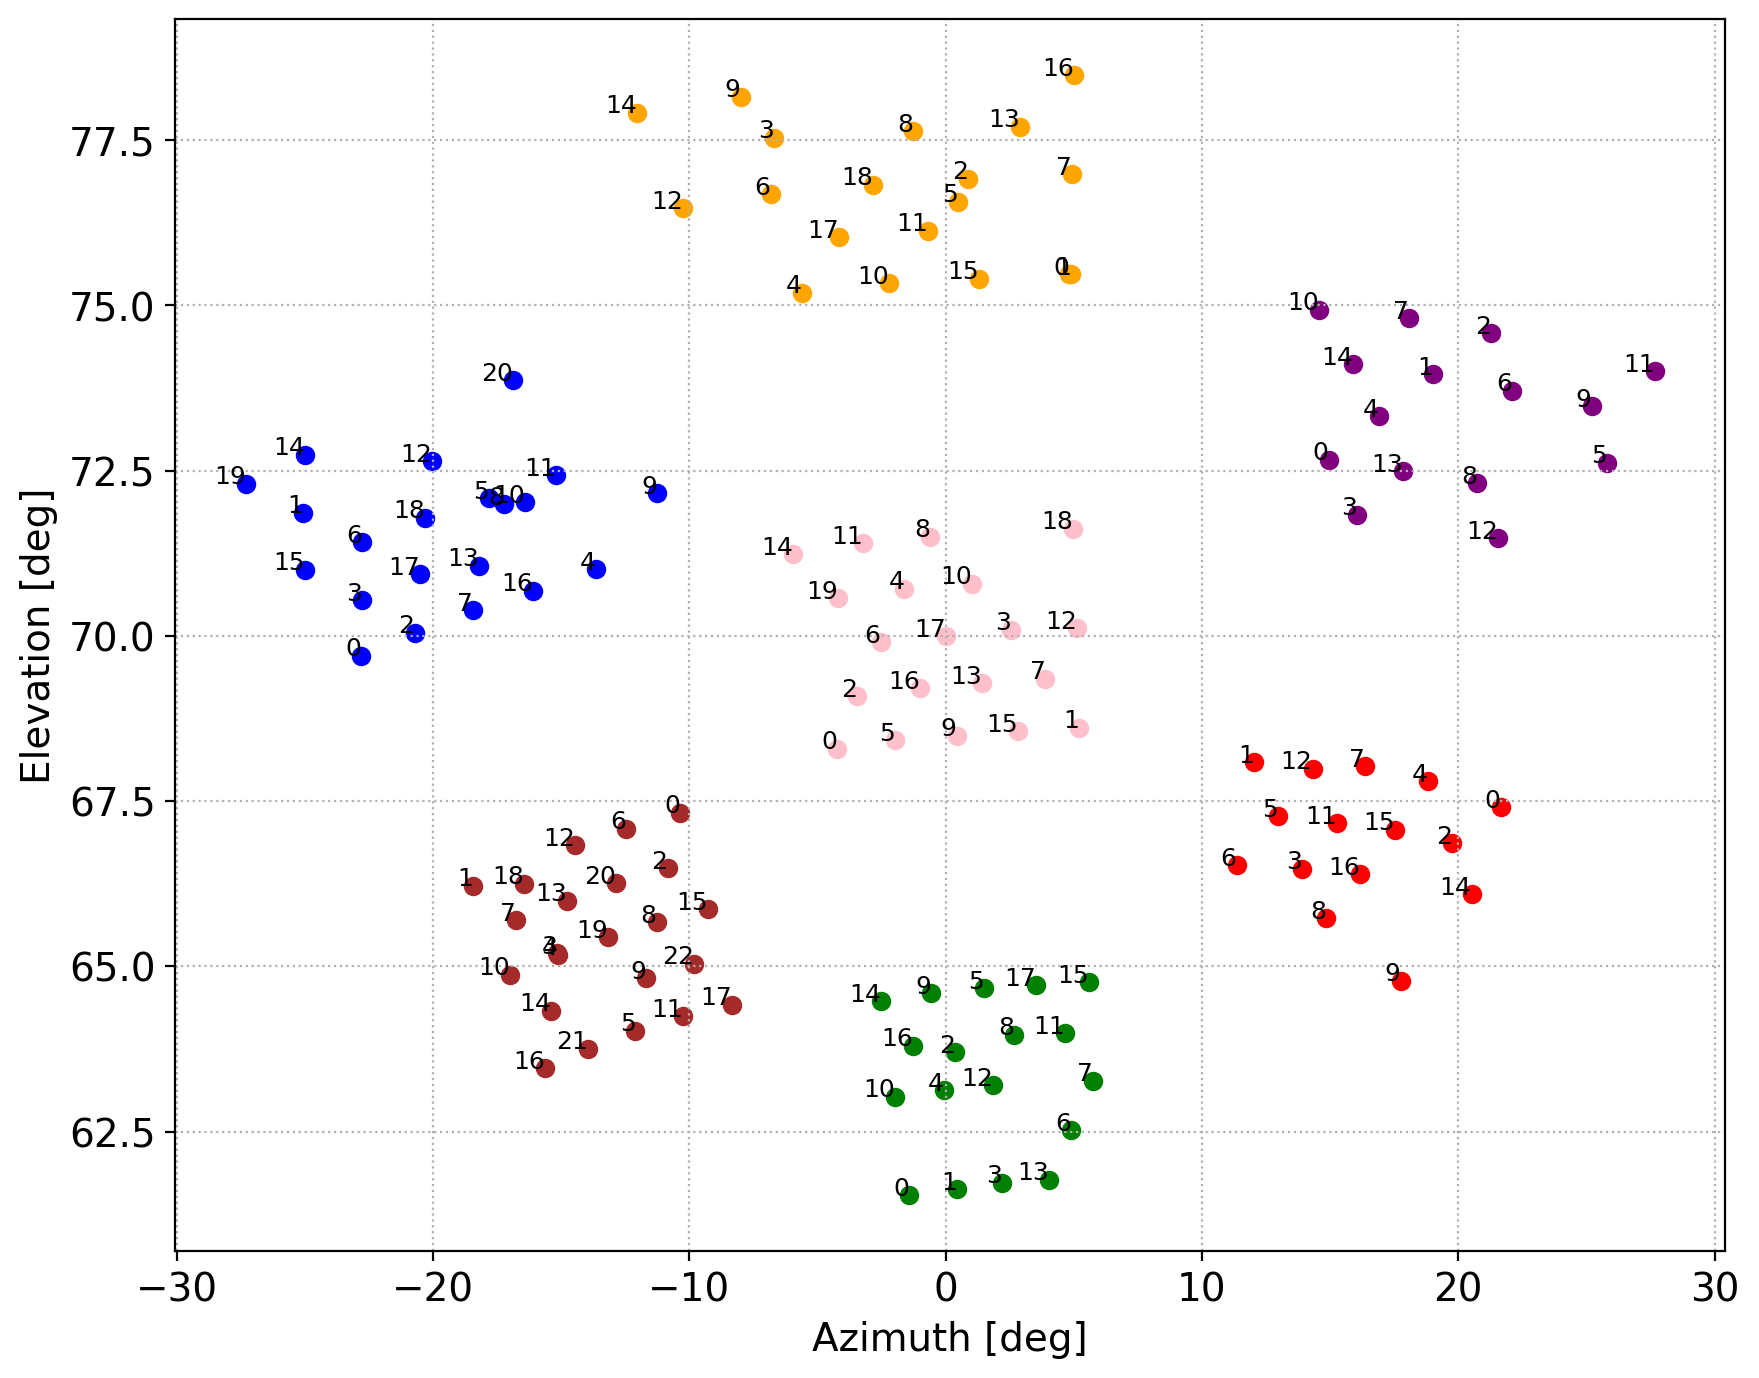

0.00011994100663059726
69.99993097009921
1.8970400501661429
1.5933320071845603


In [ ]:
sum_hpxmaps = []
maxpixs = []
nside = 1024
npix = hp.nside2npix(nside)
comb_sum_hpxmap = np.zeros(npix)

dAz = []
dEl = []

plt.figure(figsize=(10, 8))
plt.xlabel('Azimuth [deg]')
plt.ylabel('Elevation [deg]')
#plt.title('Moon Azimuth and Elevation All Wafer')
plt.grid(True)

for h, (imeas_id, ichip, ibad) in enumerate(zip(meas_ids, chips, bads)):
    chip = ichip
    meas_id = imeas_id
    print(meas_id)

    dftmp = df[df['chip'] == chip][df[df['chip'] == chip]['meas_id'] == meas_id].reset_index()

    mc_thetas = []
    mc_phis = []
    mc_phases = []
    desdatas = []
    for i in range(len(dftmp.index)):
        mcdata = read_pkl(dftmp['mcpath'][i])
        desdata = get_destripe_sqdata(mcdata, r = 1.5, maskr = 1)
        desdatas.append(desdata)
        azoff = dftmp['azoff'][i]
        eloff = dftmp['eloff'][i]
        mc_theta, mc_phi = rerot_mc70(desdata, azoff, eloff, azoffcen, eloffcen) # 度で返ってくる
        mc_thetas.append(mc_theta)
        mc_phis.append(mc_phi)
        mc_phases.append(desdata['phase'])
        del mcdata, desdata, azoff, eloff

    hitmaps, hpxmaps, maxpix, sum_hpxmap = calc_mc_map(mc_thetas, mc_phis, mc_phases)
    max_thetas = []
    max_phis = []
    labels = []
    columns = []

    for i, (theta_list, phi_list, phase_list) in enumerate(zip(mc_thetas, mc_phis, mc_phases)):
        max_phase_index = np.argmax(phase_list)
        max_theta = theta_list[max_phase_index]
        max_phi = phi_list[max_phase_index]
        max_thetas.append(max_theta)
        max_phis.append(max_phi)
        labels.append(i)
        columns.append(f'kid{i}')

    itheta_max_array = np.array(max_thetas)
    iphi_max_array = np.array(max_phis)

    filtered_iphi_max_array = [-(az - 360) if az >= 300 else -az for az in iphi_max_array]
    filtered_itheta_max_array = [90 - el for el in itheta_max_array]

    if meas_id == 7989:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)
        center_phi = iphi_center_17[17]
        center_theta = itheta_center_17[17]

        rotation_angle_1_0 = np.rad2deg(np.arctan((itheta_center_17[1] - itheta_center_17[0]) / (iphi_center_17[1] - iphi_center_17[0])))
        rotation_angle_12_6 = np.rad2deg(np.arctan((itheta_center_17[12] - itheta_center_17[6]) / (iphi_center_17[12] - iphi_center_17[6])))

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d1 = pd.DataFrame([d_az_list], columns=columns)
        df_d1.loc[1] = d_el_list
        df_d1.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='pink', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 7985:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d2 = pd.DataFrame([d_az_list], columns=columns)
        df_d2.loc[1] = d_el_list
        df_d2.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='blue', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 7983:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d3 = pd.DataFrame([d_az_list], columns=columns)
        df_d3.loc[1] = d_el_list
        df_d3.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='orange', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 7991:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d4 = pd.DataFrame([d_az_list], columns=columns)
        df_d4.loc[1] = d_el_list
        df_d4.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o',c='brown',label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 7993:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d5 = pd.DataFrame([d_az_list], columns=columns)
        df_d5.loc[1] = d_el_list
        df_d5.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o', c='green', label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 7986:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d6 = pd.DataFrame([d_az_list], columns=columns)
        df_d6.loc[1] = d_el_list
        df_d6.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17, itheta_center_17, marker='o', c='purple',label=f'{imeas_id}_chip={ichip}')
        for az, el, label in zip(iphi_center_17, itheta_center_17, labels):
            plt.text(az, el, str(label), fontsize=9, ha='right')

    elif meas_id == 7990:
        iphi_center_17 = np.array(filtered_iphi_max_array)
        itheta_center_17 = np.array(filtered_itheta_max_array)

        d_az_list = []
        d_el_list = []

        d_az = iphi_center_17 - center_phi
        d_az_list.append(d_az)

        d_el = itheta_center_17 - center_theta
        d_el_list.append(d_el)

        d_az_list = d_az_list[0].tolist()
        d_el_list = d_el_list[0].tolist()

        column_labels = list(range(1, len(d_az_list) + 1))
        df_d7 = pd.DataFrame([d_az_list], columns=columns)
        df_d7.loc[1] = d_el_list
        df_d7.index = [f"dAz{meas_id, chip}", f"dEl{meas_id, chip}"]

        dAz.append(d_az_list)
        dEl.append(d_el_list)

        plt.scatter(iphi_center_17[mask7990], itheta_center_17[mask7990], marker='o', c='red',label=f'{imeas_id}_chip={ichip}')
        for az, el, label, m  in zip(iphi_center_17, itheta_center_17, labels, mask7990):
          if m:
            plt.text(az, el, str(label), fontsize=9, ha='right')

    for i in range(len(hitmaps)):
        if i in ibad:
            pass
        elif i in []:
            pass
        else:
            sum_hpxmap[hitmaps[i]!=hp.UNSEEN] += hpxmaps[i][hitmaps[i]!=hp.UNSEEN]
            comb_sum_hpxmap[hitmaps[i]!=hp.UNSEEN] += hpxmaps[i][hitmaps[i]!=hp.UNSEEN]

    sum_hpxmaps.append(sum_hpxmap)
    maxpixs.append(maxpix)

df_sum = pd.concat([df_d1, df_d2, df_d3, df_d4, df_d5, df_d6, df_d7])
df_sum.to_csv("dAz_dEl_before_70.csv")
print(df_sum)
#plt.xlim([-30,30])
#plt.ylim([-30,30])
plt.show()